In [7]:
pip install ipywidgets

In [20]:
# DATASET CLEANER 🧹
# Run this to delete corrupt images that break the training process

from fastai.vision.all import *
import pandas as pd

def clean_dataset():
    print("🧹 Starting dataset cleanup process...")
    
    # 1. Define Paths (Absolute to avoid Windows errors)
    path = Path('../data').resolve() 
    img_path = path / 'images'
    csv_path = path / 'labels.csv'
    
    if not img_path.exists():
        print("❌ Error: Images folder not found.")
        return

    # 2. Verify Images (FastAI tries to open every single file)
    # This will detect 'platano_0.jpg' and any other broken file
    print("   ...Verifying image integrity (this may take a moment)")
    all_images = get_image_files(img_path)
    failed = verify_images(all_images)
    
    print(f"⚠️ Found {len(failed)} corrupt images.")
    
    # 3. Delete Physical Files
    for img in failed:
        try:
            img.unlink() # Delete file
            print(f"   🗑️ Deleted corrupt file: {img.name}")
        except:
            print(f"   ❌ Could not delete: {img.name}")
            
    # 4. Update CSV (Remove rows pointing to deleted files)
    if csv_path.exists() and len(failed) > 0:
        df = pd.read_csv(csv_path)
        original_count = len(df)
        
        # Function to check if the file still exists on disk
        def image_exists(fname):
            # We construct the full path combining img_path and the relative name in CSV
            full_path = img_path / fname
            return full_path.exists()
        
        # Filter: Keep only rows where the image exists
        df_clean = df[df['fname'].apply(image_exists)]
        
        # Save clean CSV
        df_clean.to_csv(csv_path, index=False)
        removed_count = original_count - len(df_clean)
        
        print(f"📝 CSV Updated: Removed {removed_count} broken references.")
        print(f"✅ Total healthy images: {len(df_clean)}")
    else:
        print("✅ No CSV update needed.")
    
    print("\n✨ Cleanup finished! You can now retry training.")

# EXECUTE CLEANUP
clean_dataset()

🧹 Starting dataset cleanup process...
   ...Verifying image integrity (this may take a moment)
⚠️ Found 0 corrupt images.
✅ No CSV update needed.

✨ Cleanup finished! You can now retry training.


c:\Users\alexc\anaconda3\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


✅ Conectado a: C:\Users\alexc\Desktop\SmartInventory\app\mlruns
📈 Total de Versiones Entrenadas: 89


,Version,Epochs,Accuracy,Loss
0,7,?,0.588889,0.703521
1,8,?,0.588889,0.000000
2,9,?,0.588889,0.729427
3,10,?,0.677778,0.623729
4,11,?,0.633333,0.709373
5,12,?,0.577778,0.788334
6,14,?,0.622222,0.708266
7,15,?,0.600000,0.690973
8,16,?,0.677778,0.643767
9,17,?,0.633333,0.643737


C:\Users\alexc\AppData\Local\Temp\ipykernel_23392\3343008330.py:80: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\alexc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


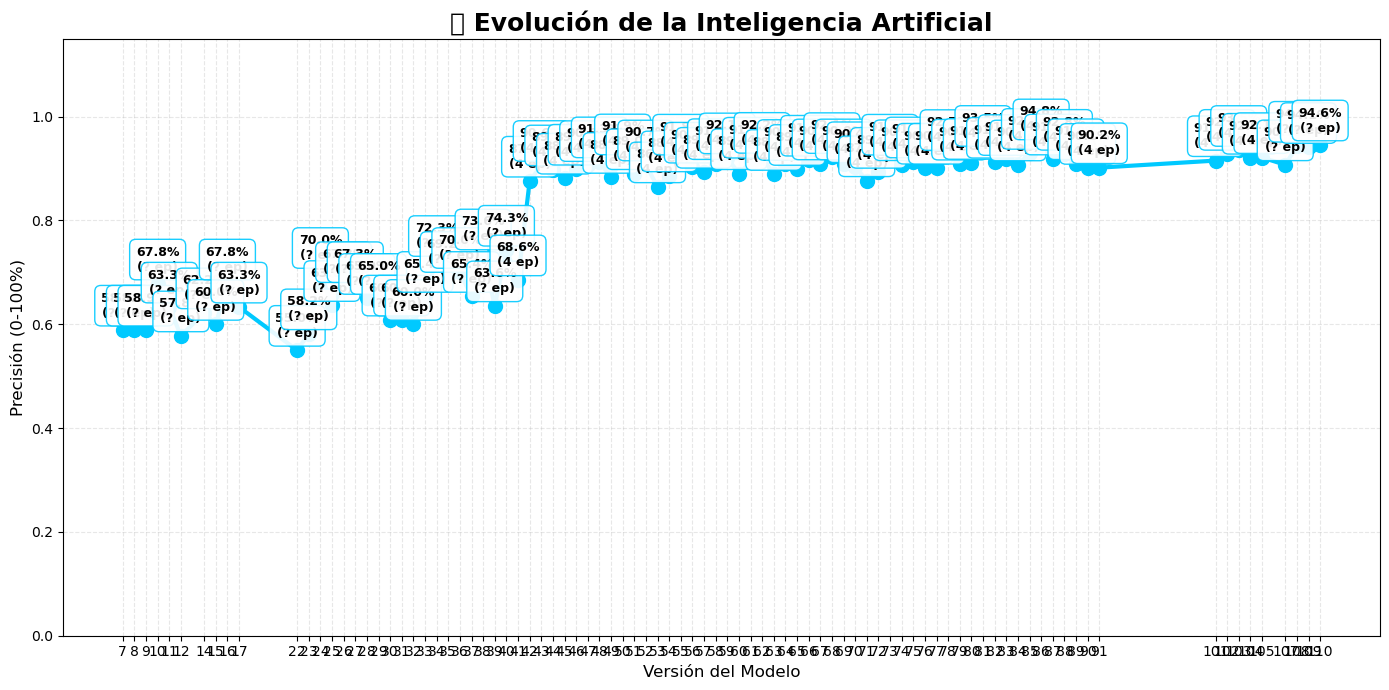

In [ ]:
# 📊 DASHBOARD DE VISUALIZACIÓN MEJORADO (Con Épocas)
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns # Opcional: Para estilos más bonitos

# 1. Conectar a los datos que generó la App
# Asumiendo que el notebook está dentro de la carpeta 'notebooks'
try:
    project_path = pathlib.Path('../').resolve()
    mlruns_path = project_path / 'app/mlruns'
    mlflow.set_tracking_uri(mlruns_path.as_uri())
    client = MlflowClient()
    print(f"✅ Conectado a: {mlruns_path}")
except:
    print("❌ Error de ruta. Verifica dónde está la carpeta 'app'.")

def show_dashboard():
    # Buscar Experimento
    exp = client.get_experiment_by_name("Smart_Inventory_Ecuador")
    if not exp:
        print("⚠️ La App aún no ha entrenado nada. Ve a la web y dale al botón de Re-entrenar.")
        return

    # Obtener historial
    runs = client.search_runs(exp.experiment_id, order_by=["start_time ASC"])
    history = []
    
    for i, run in enumerate(runs):
        if 'accuracy' in run.data.metrics:
            # Extraemos las épocas (params siempre devuelve strings, convertimos si es necesario)
            epochs = run.data.params.get('epochs', '?') 
            
            history.append({
                'Version': i + 1, 
                'Accuracy': run.data.metrics['accuracy'],
                'Loss': run.data.metrics.get('valid_loss', 0.0),
                'Epochs': epochs, # <--- AQUÍ AGREGAMOS LAS ÉPOCAS
                'Date': run.info.start_time
            })
    
    if not history:
        print("⚠️ No hay datos de métricas aún.")
        return

    # Crear Tabla
    df = pd.DataFrame(history)
    
    # --- VISUALIZACIÓN ---
    print(f"📈 Total de Versiones Entrenadas: {len(df)}")
    
    # Mostramos la tabla con la nueva columna 'Epochs'
    # Aplicamos estilo para resaltar la mejor precisión
    display(df[['Version', 'Epochs', 'Accuracy', 'Loss']].style.highlight_max(subset=['Accuracy'], color='lightgreen'))
    
    plt.figure(figsize=(14, 7))
    
    # Gráfica de Precisión
    plt.plot(df['Version'], df['Accuracy'], marker='o', color='#00C9FF', linewidth=3, markersize=10, label='Precisión')
    
    # Decoración
    plt.title('🚀 Evolución de la Inteligencia Artificial', fontsize=18, fontweight='bold')
    plt.xlabel('Versión del Modelo', fontsize=12)
    plt.ylabel('Precisión (0-100%)', fontsize=12)
    plt.ylim(0, 1.15) # Un poco más de espacio arriba
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xticks(df['Version'])
    
    # Etiquetas de datos (Porcentaje + Épocas)
    for i, row in df.iterrows():
        # Texto: "95% (4ep)"
        label_text = f"{row['Accuracy']:.1%}\n({row['Epochs']} ep)"
        
        plt.text(row['Version'], row['Accuracy'] + 0.02, label_text, 
                 ha='center', va='bottom', fontweight='bold', fontsize=9, 
                 bbox=dict(facecolor='white', alpha=0.9, edgecolor='#00C9FF', boxstyle='round,pad=0.5'))
        
    plt.tight_layout()
    plt.show()

# Ver el Dashboard
show_dashboard()